In [1]:
import pandas as pd
import plotly.express as px
from scipy.stats import shapiro, anderson, kstest, normaltest
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import shapiro, anderson, kstest, normaltest
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import missingno as msno
from sklearn.preprocessing import LabelEncoder
import pandas_dq
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import cleanlab


Imported pandas_dq (1.9). Always upgrade to get latest version.



In [55]:
import pandas_dq
import pandas as pd
from sklearn.preprocessing import LabelEncoder
data = pd.read_csv('datasets\iris.csv')
le = LabelEncoder()

# Fit the encoder to the Species column
le.fit(data['Species'])

# Transform the Species column using the fitted encoder
data['Species'] = le.transform(data['Species'])
report = pandas_dq.dq_report(data, target='Species', csv_engine="pandas", verbose=1)
reportDICT = report.to_dict()
df = pd.DataFrame(reportDICT)
print(df)
# reportdf = pd.DataFrame.from_dict(reportDICT)
# print(reportdf.head())
#
# #print(reportJSON)
# reportDICT = report.to_dict()
# reportdf = pd.DataFrame.from_dict(reportDICT)
# print(reportdf.head())
# with open('htmlcode.txt', 'w') as f:
#     f.write(reportDICT)
#print(reportDICT)

,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
Id,int64,0.000000,100,1.000000,150.000000,"Possible ID colum: drop before modeling process., Id has a correlation >= 0.8 with Species. Possible data leakage. Double check this variable."
SepalLengthCm,float64,0.000000,NA,4.300000,7.900000,No issue
SepalWidthCm,float64,0.000000,NA,2.000000,4.400000,has 4 outliers greater than upper bound (4.05) or lower than lower bound(2.05). Cap them or remove them.
PetalLengthCm,float64,0.000000,NA,1.000000,6.900000,"has a high correlation with ['Id', 'SepalLengthCm']. Consider dropping one of them., PetalLengthCm has a correlation >= 0.8 with Species. Possible data leakage. Double check this variable."
PetalWidthCm,float64,0.000000,NA,0.100000,2.500000,"has a high correlation with ['Id', 'SepalLengthCm', 'PetalLengthCm']. Consider dropping one of them., PetalWidthCm has a correlation >= 0.8 with Species. Possible data leakage. Double check this variable."
Species,int32,0.000000,2,0.000000,2.000000,"has a high correlation with ['Id', 'PetalLengthCm', 'PetalWidthCm']. Consider dropping one of them."


              Data Type  Missing Values% Unique Values%  Minimum Value  \
Id             int64     0.0              100            1.0             
SepalLengthCm  float64   0.0              NA             4.3             
SepalWidthCm   float64   0.0              NA             2.0             
PetalLengthCm  float64   0.0              NA             1.0             
PetalWidthCm   float64   0.0              NA             0.1             
Species        int32     0.0              2              0.0             

               Maximum Value  \
Id             150.0           
SepalLengthCm  7.9             
SepalWidthCm   4.4             
PetalLengthCm  6.9             
PetalWidthCm   2.5             
Species        2.0             

                                                                                                                                                                                                                       DQ Issue  
Id             Possible ID col

In [56]:
from pandas_dq import Fix_DQ
fdq = Fix_DQ()

X_train_transformed = fdq.fit_transform(data)


1 ID cols will be dropped from further processing: ['Id']
    Dropping PetalLengthCm which has a high correlation with ['Id', 'SepalLengthCm']
    Dropping PetalWidthCm which has a high correlation with ['Id', 'SepalLengthCm', 'PetalLengthCm']
    Dropping Species which has a high correlation with ['Id', 'PetalLengthCm', 'PetalWidthCm']


In [57]:
report = pandas_dq.dq_report(X_train_transformed, target=None, csv_engine="pandas", verbose=1)

Alert: Dropping 34 duplicate rows can sometimes cause column data types to change to object. Double-check!


,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
SepalLengthCm,float64,0.000000,NA,4.300000,7.900000,No issue
SepalWidthCm,float64,0.000000,NA,2.000000,4.050000,has 1 outliers greater than upper bound (4.05) or lower than lower bound(2.05). Cap them or remove them.


In [58]:
import cleanlab
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
df = pd.read_csv('datasets\Iris.csv')
# Create a label encoder object
le = LabelEncoder()
# Fit and transform the "Species" column
df['Species'] = le.fit_transform(df['Species'])
def cleanlab_test(df):

    # cleanlab works with **any classifier**. Yup, you can use PyTorch/TensorFlow/OpenAI/XGBoost/etc.
    cl = cleanlab.classification.CleanLearning(RandomForestClassifier())
    data = df.loc[:, df.columns != 'class']

    # cleanlab finds data and label issues in **any dataset**... in ONE line of code!
    # Fit model to messy, real-world data, automatically training on cleaned data.
    _ = cl.fit(data, df['class'])
    # See the label quality for every example, which data has issues, and more.
    print(cl.get_label_issues())

In [59]:
from deepchecks.tabular import Dataset
import deepchecks.tabular.checks
import pandas as pd
from sklearn.datasets import load_iris
from deepchecks.tabular.datasets.classification.phishing import load_data
import numpy as np
from deepchecks.tabular.datasets.classification import adult
import plotly.express as px
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

deepchecks - WARNING - You are using deepchecks version 0.11.1, however a newer version is available.Deepchecks is frequently updated with major improvements. You should consider upgrading via the "python -m pip install --upgrade deepchecks" command.


In [60]:
def encode_categorical_columns(dataset, target, data_types):
    # Find all categorical columns
    # TODO: regel hieronder aanpassen naar wat de user heeft ingegeven (let hierbij op strings als dtype, moeten gezien worden als categorical)
    categorical_cols = dataset.select_dtypes(include=['object', 'category']).columns.tolist()

    target_is_categorical = False
    if target != 'None':
        # remove target as we want to label encode this (for classification problems)
        if target in categorical_cols:
            target_is_categorical = True
            categorical_cols.remove(target)

            # label encode target
            le = LabelEncoder()
            encoded_target = le.fit_transform(dataset[target])
            # replace target column with label encoded values
            dataset.drop(columns=[target], inplace=True)
            dataset[target] = encoded_target

    if not categorical_cols:  # then no features are categorical, and we're done
        return dataset

    # if there are categorical columns, we want to one-hot-encode them

    # encode categoricals
    encoder = OneHotEncoder(handle_unknown='ignore', max_categories=100)
    encoded_columns = encoder.fit_transform(dataset[categorical_cols])
    new_columns = pd.DataFrame(encoded_columns.toarray(), columns=encoder.get_feature_names_out(categorical_cols))

    # add new columns to df and drop old ones
    dataset_encoded = pd.concat([dataset, new_columns], axis=1)
    dataset_encoded = dataset_encoded.drop(columns=categorical_cols)

    # reposition target column to the end of the dataframe
    if target != 'None' and target_is_categorical:
        dataset_encoded.drop(columns=[target], inplace=True)
        dataset_encoded[target] = encoded_target

    #XGBClassifier doesn't accept: [, ] or <, so loop over the columns and change the names if they contain such values
    new_col_names = {col: col.replace('<', '(smaller than)').replace('[', '(').replace(']', ')') for col in dataset_encoded.columns}
    dataset_encoded = dataset_encoded.rename(columns=new_col_names)

    return dataset_encoded

In [61]:
def wrong_label(encoded_dataset, target):
    """"Function that finds potential label errors (due to annotator mistakes), edge cases, and otherwise ambiguous examples"""
    model_XGBC = XGBClassifier(tree_method="hist", enable_categorical=True) #hist is fastest tree method of XGBoost
    #TODO: add more models and choose whichever gives highest prediction? Downside --> slows process
    data_no_labels = encoded_dataset.drop(columns=[target])
    labels = encoded_dataset[target]
    pred_probs = cross_val_predict(model_XGBC, data_no_labels, labels, method='predict_proba')

    preds = np.argmax(pred_probs, axis=1)
    acc_original = accuracy_score(preds, labels)
    print(f"Accuracy with original data: {round(acc_original * 100, 1)}%")

    #use cleanlab's built in confident learning method to find label issues
    cl = cleanlab.classification.CleanLearning()
    issues_dataframe = cl.find_label_issues(X=None, labels=labels, pred_probs=pred_probs)
    wrong_label_count = (issues_dataframe['is_label_issue'] == True).sum()

    #filter df so only errors are visible
    issues_dataframe_only_errors = issues_dataframe[issues_dataframe['is_label_issue'] == True]

    return issues_dataframe, issues_dataframe_only_errors, wrong_label_count

In [62]:
from scipy.io.arff import loadarff

raw_data = loadarff('datasets/dataset_31_credit-g.arff')
df_data = pd.DataFrame(raw_data[0])
#df_data.drop(columns=['checking_status', 'savings_status', 'employment'], inplace=True)
encdoded_data = encode_categorical_columns(df_data, 'class', None)
# pred_probs, labels = wrong_label(encdoded_data, 'class')

wrong_label(encdoded_data, 'class')

# cl = cleanlab.classification.CleanLearning()
# issues_dataframe = cl.find_label_issues(X=None, labels=labels, pred_probs=pred_probs, return_indices_ranked_by='self_confidence')
# print(issues_dataframe)

Accuracy with original data: 75.7%


(     is_label_issue  label_quality  given_label  predicted_label
 0    False           0.982974       1            1              
 1    False           0.896697       0            0              
 2    False           0.995315       1            1              
 3    True            0.405909       1            0              
 4    False           0.830484       0            0              
 5    False           0.963891       1            1              
 6    False           0.997703       1            1              
 7    False           0.887332       1            1              
 8    False           0.999295       1            1              
 9    False           0.949440       0            0              
 10   False           0.933829       0            0              
 11   False           0.995936       0            0              
 12   False           0.600553       1            1              
 13   False           0.675812       0            0              
 14   True

In [63]:
import plotly.express as px
df = pd.read_csv('datasets/iris.csv')
print(df.head())


def pcp_plot(encoded_df, target):
    #TODO: tekst/lookup table toevoegen met conversie categorische variabelen encoding

    if target != 'None':
        fig = px.parallel_coordinates(encoded_df, color=target)
    else:
        fig = px.parallel_coordinates(encoded_df)


    return fig


df_encoded = encode_categorical_columns(df, 'target', None)
fig = px.parallel_coordinates(df_encoded, color='target')
fig.show()

   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0  1   5.1            3.5           1.4            0.2           Iris-setosa
1  2   4.9            3.0           1.4            0.2           Iris-setosa
2  3   4.7            3.2           1.3            0.2           Iris-setosa
3  4   4.6            3.1           1.5            0.2           Iris-setosa
4  5   5.0            3.6           1.4            0.2           Iris-setosa


ValueError: Value of 'color' is not the name of a column in 'data_frame'. Expected one of ['Id', 'SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'Species_Iris-setosa', 'Species_Iris-versicolor', 'Species_Iris-virginica'] but received: target

In [ ]:
def encode_categorical_columns(dataset, target, data_types):
    # Find all categorical columns
    # TODO: regel hieronder aanpassen naar wat de user heeft ingegeven (let hierbij op strings als dtype, moeten gezien worden als categorical)
    categorical_cols = dataset.select_dtypes(include=['object', 'category']).columns.tolist()

    target_is_categorical = False
    if target != 'None':
        # remove target as we want to label encode this (for classification problems)
        if target in categorical_cols:
            target_is_categorical = True
            categorical_cols.remove(target)

            # label encode target
            le = LabelEncoder()
            encoded_target = le.fit_transform(dataset[target])
            # replace target column with label encoded values
            dataset.drop(columns=[target], inplace=True)
            dataset[target] = encoded_target

    if not categorical_cols:  # then no features are categorical, and we're done
        return dataset

    # if there are categorical columns, we want to one-hot-encode them

    # encode categoricals
    encoder = OneHotEncoder(handle_unknown='ignore', max_categories=100)
    encoded_columns = encoder.fit_transform(dataset[categorical_cols])
    new_columns = pd.DataFrame(encoded_columns.toarray(), columns=encoder.get_feature_names_out(categorical_cols))

    # add new columns to df and drop old ones
    dataset_encoded = pd.concat([dataset, new_columns], axis=1)
    dataset_encoded = dataset_encoded.drop(columns=categorical_cols)

    # reposition target column to the end of the dataframe
    if target != 'None' and target_is_categorical:
        dataset_encoded.drop(columns=[target], inplace=True)
        dataset_encoded[target] = encoded_target

    #XGBClassifier doesn't accept: [, ] or <, so loop over the columns and change the names if they contain such values
    new_col_names = {col: col.replace('<', '(smaller than)').replace('[', '(').replace(']', ')') for col in dataset_encoded.columns}
    dataset_encoded = dataset_encoded.rename(columns=new_col_names)

    return dataset_encoded

In [ ]:
import missingno as msno

def missingno_plot(df):

    msno_plot = msno.matrix(df)

    return msno_plot


df = pd.read_csv('datasets/titanic_train.csv')
print(df.head())

missingno_plot(df)

In [ ]:
from sklearn.tree
def plot_feature_importance(X, y, feature_names):
    """
    Predicts the feature importance using a random forest and plots it.

    Parameters:
    -----------
    X : numpy array, shape (n_samples, n_features)
        The input data.
    y : numpy array, shape (n_samples,)
        The target values.
    feature_names : list of strings, shape (n_features,)
        The names of the features.

    Returns:
    --------
    None
    """
    # Initialize the random forest regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=42)

    # Fit the random forest to the data
    rf.fit(X, y)

    # Get the feature importances
    feature_importances = rf.feature_importances_

    # Sort the feature importances in descending order
    indices = np.argsort(feature_importances)[::-1]

    # Plot the feature importances
    plt.figure()
    plt.title("Feature Importance")
    plt.bar(range(X.shape[1]), feature_importances[indices])
    plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
    plt.tight_layout()
    plt.show()




# Generate some random data
X = np.random.rand(100, 5)
y = np.random.rand(100)

# Define the feature names
feature_names = ["Feature 1", "Feature 2", "Feature 3", "Feature 4", "Feature 5"]

# Call the function to plot the feature importance
plot_feature_importance(X, y, feature_names)

In [ ]:
import sortinghatinf



In [ ]:
dict = {'Data Type': {'Id': 'dtype(int64)', 'SepalLengthCm': 'dtype(int64)', 'SepalWidthCm': 'dtype(int64)', 'PetalLengthCm': 'dtype(int64)', 'PetalWidthCm': 'dtype(int64)', 'Species': 'dtype(int64)'}, 'Missing Values%': {'Id': 0.0, 'SepalLengthCm': 0.0, 'SepalWidthCm': 0.0, 'PetalLengthCm': 0.0, 'PetalWidthCm': 0.0, 'Species': 0.0}, 'Unique Values%': {'Id': 100, 'SepalLengthCm': 'NA', 'SepalWidthCm': 'NA', 'PetalLengthCm': 'NA', 'PetalWidthCm': 'NA', 'Species': 2}, 'Minimum Value': {'Id': 1.0, 'SepalLengthCm': 4.3, 'SepalWidthCm': 2.0, 'PetalLengthCm': 1.0, 'PetalWidthCm': 0.1, 'Species': 0.0}, 'Maximum Value': {'Id': 150.0, 'SepalLengthCm': 7.9, 'SepalWidthCm': 4.4, 'PetalLengthCm': 6.9, 'PetalWidthCm': 2.5, 'Species': 2.0}, 'DQ Issue': {'Id': 'Possible ID colum: drop before modeling process.,     Id has a correlation >= 0.8 with Species. Possible data leakage. Double check this variable.', 'SepalLengthCm': 'No issue', 'SepalWidthCm': 'has 4 outliers greater than upper bound (4.05) or lower than lower bound(2.05). Cap them or remove them.', 'PetalLengthCm': "has a high correlation with ['Id', 'SepalLengthCm']. Consider dropping one of them.,     PetalLengthCm has a correlation >= 0.8 with Species. Possible data leakage. Double check this variable.", 'PetalWidthCm': "has a high correlation with ['Id', 'SepalLengthCm', 'PetalLengthCm']. Consider dropping one of them.,     PetalWidthCm has a correlation >= 0.8 with Species. Possible data leakage. Double check this variable.", 'Species': "has a high correlation with ['Id', 'PetalLengthCm', 'PetalWidthCm']. Consider dropping one of them."}}

import pandas as pd
from typing import Dict

def dict_to_dataframe(d: Dict[str, Dict[str, any]]) -> pd.DataFrame:
    data = {}
    for key in d:
        for sub_key, value in d[key].items():
            if sub_key not in data:
                data[sub_key] = []
            data[sub_key].append(value)
    return pd.DataFrame(data)
output = dict_to_dataframe(dict)
print(output.head())

In [11]:
import pandas as pd
from itertools import product
import numpy as np

def sensitive_feature_combinations(dataset_original, sensitive_features, target_column, bins=5):
    # Create a copy of the dataset to avoid modifying the original data
    if sensitive_features:
        dataset = dataset_original.copy()
        #TODO: callback maken die sensitive features ingeeft
        #TODO: iets bedenken voor regression
        #bin numeric sensitive features into 5 bins
        for feat in sensitive_features:
            if pd.api.types.is_numeric_dtype(dataset[feat]):        #TODO: baseren op data type inference sortinghat
            #if dtypes[col] == 'floating' or dtypes[col] == 'numeric' or dtypes[col] == 'integer':
                dataset[feat] = pd.cut(dataset[feat], bins=bins)

        #obtain all combinations of sensitive features
        sensitive_combinations = list(product(*[dataset[feat].unique() for feat in sensitive_features]))
        #print(sensitive_combinations)
        # Initialize empty dictionary to store counts
        counts = {}

        # Loop through each sensitive feature combination
        for combo in sensitive_combinations:
            # Create a mask for rows that match the current combination
            mask = True
            for i, feat in enumerate(sensitive_features):
                mask = mask & (dataset[feat] == combo[i])

            # Count the number of rows that match the mask and the target value
            count = dataset.loc[mask, target_column].value_counts()

            # Store the count in the dictionary
            counts[combo] = count.to_dict()

        # Convert dictionary to a pandas DataFrame
        result = pd.DataFrame.from_dict(counts, orient='index').fillna(0)

        # Add a column for the total count
        result['count'] = result.sum(axis=1)

        # Add a column for the sensitive feature combination
        result['sensitive_features'] = result.index.map(lambda x: ', '.join(map(str, x)))

        # Reorder the columns
        result = result[['sensitive_features', 'count'] + list(dataset[target_column].unique())]

        return result

    else: #no sensitive features selected
        return None

In [14]:
data = pd.read_csv('datasets/adult.csv')
data.head()
sensitive_features = None #['race', 'gender', 'age']
target_column = 'income'
# Permanently changes the pandas settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# # All dataframes hereafter reflect these changes.
# display(df)
#
# print('**RESET_OPTIONS**')
#
# # Resets the options
# pd.reset_option('all')

print(sensitive_feature_combinations(data, sensitive_features, target_column, bins=5))


None


In [15]:
# Call the sensitive_feature_combinations function to get the counts table
counts_table = sensitive_feature_combinations(data, sensitive_features, target_column)


def plot_stacked_barchart(sensitive_feature_counts_table):
    """"creates a plotly stacked bar chart to display the distribution of class labels per sensitive subgroup"""
    #table always looks the same (sensitive features (vary in amount), count, class labels (vary in amount))
    #TODO: fix in  dash inbouwen dat als sensitive_feature_counts_table None is, hij deze functie niet aanroept, en regression anders
    list_of_labels = list(sensitive_feature_counts_table.columns)
    list_of_labels.remove('sensitive_features')
    list_of_labels.remove('count')
    fig = px.bar(sensitive_feature_counts_table, x=list_of_labels, y='sensitive_features', barmode='stack', title='Sensitive Feature Combinations vs Target Column', orientation='h')
    # Set the x-axis title
    fig.update_xaxes(title_text='Count')

    return fig

fig = plot_stacked_barchart(counts_table)
fig.show()


AttributeError: 'NoneType' object has no attribute 'columns'

In [12]:
data = pd.read_csv('datasets/german_credit_data.csv')
data.head()
sensitive_features = ['Age', 'Sex', 'Job', 'Saving accounts']
target_column = 'Housing'
counts_table = sensitive_feature_combinations(data, sensitive_features, target_column)
print(counts_table)
fig = plot_stacked_barchart(counts_table)
fig.show()

NameError: name 'sensitive_feature_combinations' is not defined

In [144]:
import pandas as pd
import plotly.express as px

def plot_dataset_distributions(data, dtypes):
    """"plots the distributions per column in the dataset"""
    # Initialize an empty list to store the figures
    figs = []

    #each datatypre requires different plotting
    for col in data.columns:
        #histogram for numerical values
        if dtypes[col] == 'floating' or dtypes[col] == 'numeric' or dtypes[col] == 'integer':
            fig = px.histogram(data, x=col, title=f'{col} distribution')
            figs.append(fig)

        #bar chart for categoricals & booleans
        elif dtypes[col] == 'boolean':
            fig = px.bar(data, x=col, color=col, title=f'{col} distribution')
            figs.append(fig)
        elif dtypes[col] == 'categorical':
            fig = px.bar(data, x=col, title=f'{col} distribution')
            figs.append(fig)

        #for sentences, create a word cloud
        elif dtypes[col] == 'sentence':
            word_counts = data[col].str.split(expand=True).stack().value_counts()
            fig = px.bar(x=word_counts.index, y=word_counts.values, title=f'{col} word cloud')
            fig.update_layout(xaxis={'categoryorder':'total descending'})
            figs.append(fig)

    return figs


In [147]:
dict = {'4046': 'floating', '4225': 'floating', '4770': 'floating', 'Date': 'datetime', 'AveragePrice': 'floating', 'Total Volume': 'floating', 'Total Bags': 'floating', 'Small Bags': 'floating', 'Large Bags': 'floating', 'XLarge Bags': 'floating', 'type': 'categorical', 'year': 'categorical', 'region': 'categorical'}
lijstje = ['4046', '4225']
for col in lijstje:
    print(dict[col])

floating
floating


In [137]:
import sortinghatinf #algorithm to predict the feature type out og [numeric, categorical, datetime, sentence,
def obtain_feature_type_table(df):
    """"Function to predict the feature types
    INPUT: pandas DataFrame
    OUTPUT: Pandas DataFrame with feature types at index 0 and nothing else : [column names ]
                                                                              [feature_types]
    """
    #print('df.columns:', list(df.columns))
    predicted_feature_types = sortinghatinf.get_expanded_feature_types(df)
    feature_type_table = pd.DataFrame(columns=list(df.columns))
    feature_type_table.loc[len(feature_type_table)] = predicted_feature_types

    return feature_type_table


In [143]:
feature_type_table = obtain_feature_type_table(data)
print(list(feature_type_table.columns))
print(list(feature_type_table.iloc[0]))



['Unnamed: 0', 'Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose']
['not-generalizable', 'integer', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'integer', 'integer', 'categorical']


In [5]:
def wrong_label(encoded_dataset, target):
    """"Function that finds potential label errors (due to annotator mistakes), edge cases, and otherwise ambiguous examples"""
    model_XGBC = XGBClassifier(tree_method="hist", enable_categorical=True)  # hist is fastest tree method of XGBoost, use default model
    # TODO: def main problem? testen

    data_no_labels = encoded_dataset.drop(columns=[target])
    labels = encoded_dataset[target]

    #obtain predicted probabilities using 5 fold cross validation
    pred_probs = cross_val_predict(model_XGBC, data_no_labels, labels, method='predict_proba')

    preds = np.argmax(pred_probs, axis=1)
    acc_original = accuracy_score(preds, labels)
    print(f"Accuracy with original data: {round(acc_original * 100, 1)}%")
    print(model_XGBC.feature_importances_)
    #use cleanlabs built in confident learning method to find label issues
    # cl = cleanlab.classification.CleanLearning()
    # issues_dataframe = cl.find_label_issues(X=None, labels=labels, pred_probs=pred_probs)
    # wrong_label_count = (issues_dataframe['is_label_issue'] == True).sum()
    #
    # # filter df so only errors are visible
    # issues_dataframe_only_errors = issues_dataframe[issues_dataframe['is_label_issue'] == True]

    return None #issues_dataframe, issues_dataframe_only_errors, wrong_label_count







In [2]:
def encode_categorical_columns(dataset, target, data_types):
    # Find all categorical columns
    # TODO: regel hieronder aanpassen naar wat de user heeft ingegeven (let hierbij op strings als dtype, moeten gezien worden als categorical)
    categorical_cols = dataset.select_dtypes(include=['object', 'category']).columns.tolist()

    target_is_categorical = False
    if target != 'None':
        print('checkpoint 1')
        # remove target as we want to label encode this (for classification problems)
        if target in categorical_cols:
            target_is_categorical = True
            categorical_cols.remove(target)

            # label encode target
            le = LabelEncoder()
            encoded_target = le.fit_transform(dataset[target])
            print('checkpoint 2')
            # replace target column with label encoded values
            dataset.drop(columns=[target], inplace=True)
            dataset[target] = encoded_target

    if not categorical_cols:  # then no features are categorical, and we're done
        return dataset
    print('checkpoint 3')

    # if there are categorical columns, we want to one-hot-encode them

    # encode categoricals
    encoder = OneHotEncoder(handle_unknown='ignore', max_categories=100)
    encoded_columns = encoder.fit_transform(dataset[categorical_cols])
    print('checkpoint 4')
    new_columns = pd.DataFrame(encoded_columns.toarray(), columns=encoder.get_feature_names_out(categorical_cols))

    # add new columns to df and drop old ones
    dataset_encoded = pd.concat([dataset, new_columns], axis=1)
    dataset_encoded = dataset_encoded.drop(columns=categorical_cols)

    # reposition target column to the end of the dataframe
    print('checkpoint 5')
    if target != 'None' and target_is_categorical:
        dataset_encoded.drop(columns=[target], inplace=True)
        dataset_encoded[target] = encoded_target
    print('checkpoint 6')
    #XGBClassifier doesn't accept: [, ] or <, so loop over the columns and change the names if they contain such values
    new_col_names = {col: col.replace('<', '(smaller than)').replace('[', '(').replace(']', ')') for col in dataset_encoded.columns}
    dataset_encoded = dataset_encoded.rename(columns=new_col_names)

    return dataset_encoded

In [29]:
data = pd.read_csv('datasets/adult.csv')
data.head()
encoded_dataset = encode_categorical_columns(data, 'income', None)

checkpoint 1
checkpoint 2
checkpoint 3
checkpoint 4
checkpoint 5
checkpoint 6


In [6]:
issues_dataframe, issues_dataframe_only_errors, wrong_label_count = wrong_label(encoded_dataset, 'income')

Accuracy with original data: 87.3%


NotFittedError: need to call fit or load_model beforehand

In [30]:
def plot_feature_importance(df, target):
    """
    Trains a random forest classifier on the input data and target column, and plots
    the feature importance using a horizontal bar chart.

    Parameters:
    data (pandas.DataFrame): input data
    target_col (str): name of the target column

    Returns:
    None
    """
    te = TargetEncoder()
    #split target from data
    x = df.drop(columns=[target])
    y = df[target]
    x = te.fit_transform(x, y)
    #train random forest classifier / regressor depending on task type
    #TODO: werkend voor regression maken (afhangend van dtypes)
    rf = RandomForestClassifier(n_jobs=-1)
    rf.fit(x, y)

    #obtain feature importances
    feature_importances = rf.feature_importances_

    #create df from them
    df_feature_importances = pd.DataFrame({
        'feature': x.columns,
        'importance': feature_importances
    })

    #horizontal barchart
    fig = px.bar(df_feature_importances.sort_values('importance', ascending=False),
                 x='importance', y='feature', orientation='h',
                 title='Feature Importance')
    return fig

from category_encoders.target_encoder import TargetEncoder
fig = plot_feature_importance(data, 'income')
fig.show()

C:\Users\robin\AppData\Local\Programs\Python\Python310\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning:

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327

C:\Users\robin\AppData\Local\Programs\Python\Python310\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning:

Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327



In [28]:
 data.head()


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,0
1,2,4.9,3.0,1.4,0.2,0
2,3,4.7,3.2,1.3,0.2,0
3,4,4.6,3.1,1.5,0.2,0
4,5,5.0,3.6,1.4,0.2,0


matplotlib.axes._subplots.AxesSubplot

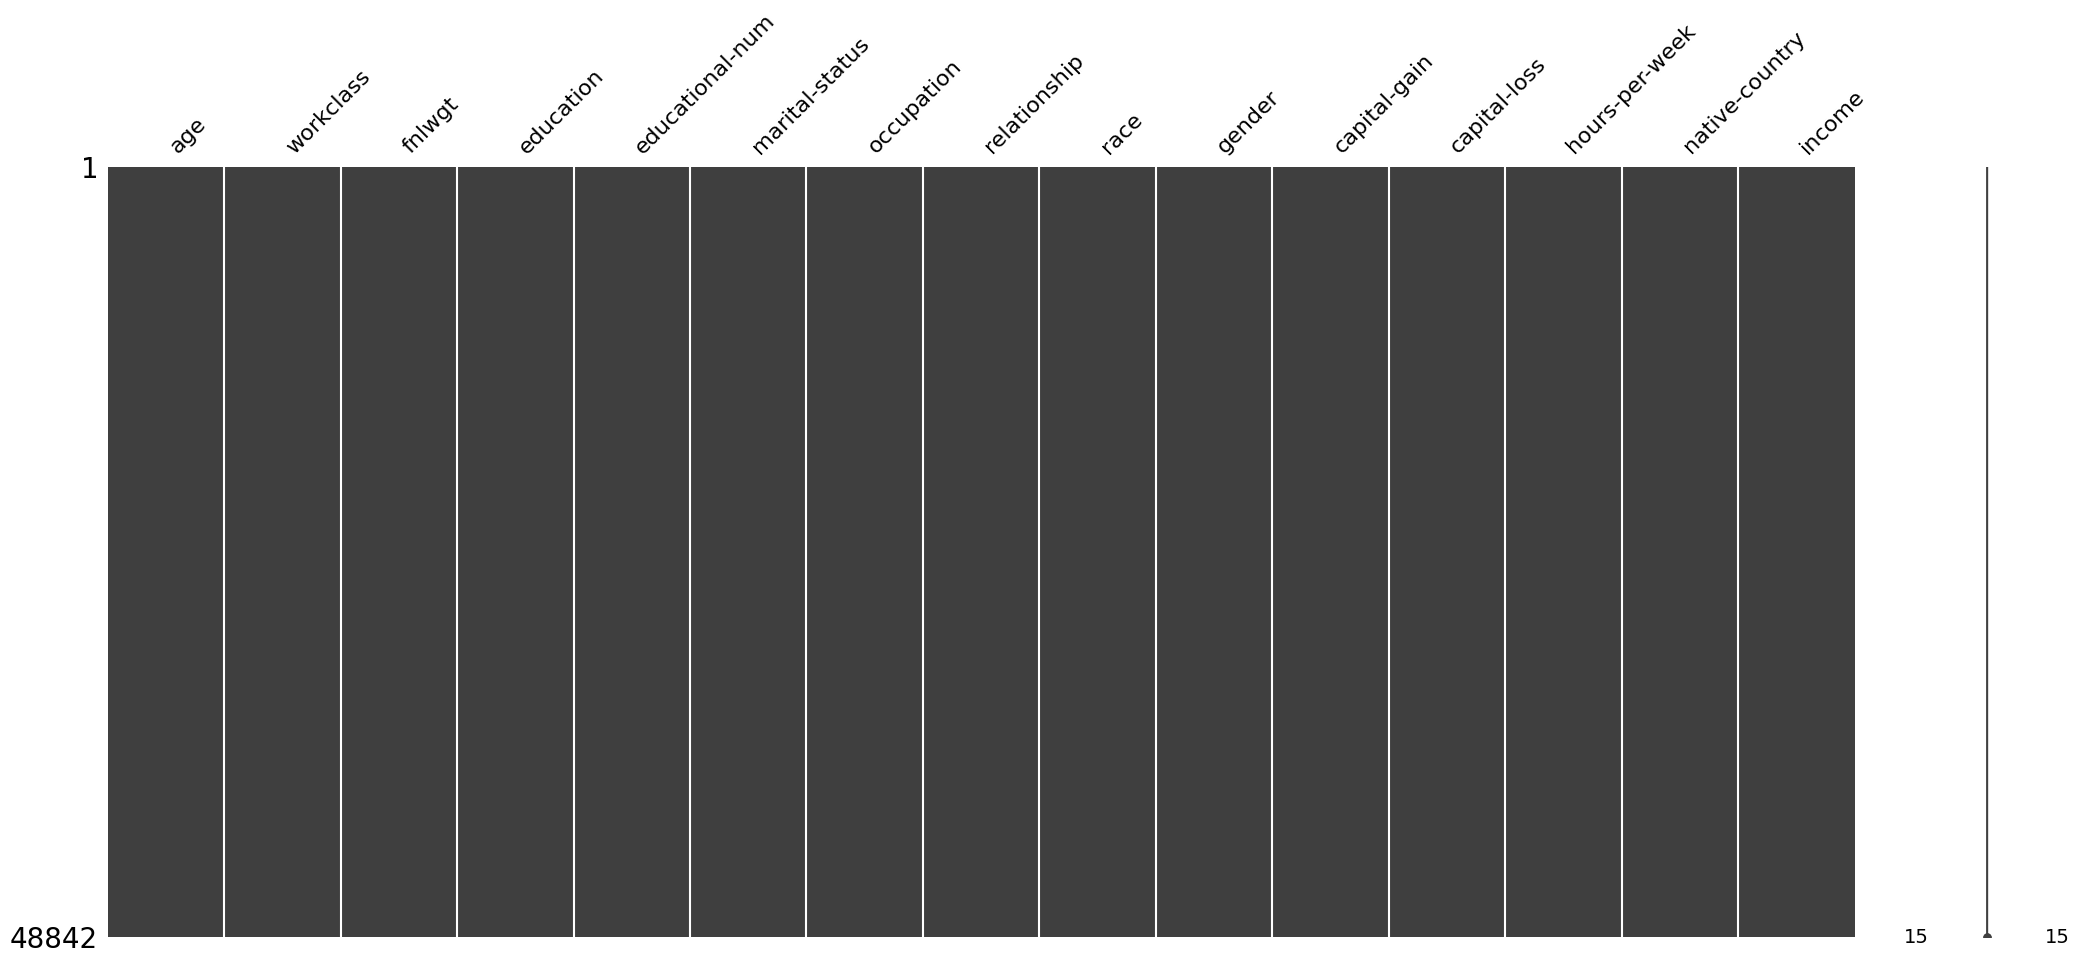

In [21]:
import plotly.tools

def missingno_plot(df):

    msno_plot = msno.matrix(df)

    return msno_plot

plot = missingno_plot(data)
type(plot)

#plotly_plot = plotly.tools.mpl_to_plotly(plot)


In [25]:
data = pd.read_csv('datasets/iris.csv')
dtypes_dict = {'Id': 'not-generalizable', 'SepalLengthCm': 'floating', 'SepalWidthCm': 'floating', 'PetalLengthCm': 'floating', 'PetalWidthCm': 'floating', 'Species': 'categorical'}
encoded_data = encode_categorical_columns(data, 'Species', dtypes_dict)
pcp_plot(encoded_data, target='Species')

checkpoint 1
checkpoint 2


C:\Users\robin\AppData\Local\Programs\Python\Python310\lib\site-packages\plotly\express\_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [24]:
def pcp_plot(encoded_df, target):
    #TODO: tekst/lookup table toevoegen met conversie categorische variabelen encoding als dictionary

    if target != 'None':
        fig = px.parallel_coordinates(encoded_df, color=target)
    else:
        fig = px.parallel_coordinates(encoded_df)

    return fig

In [31]:

def main():
    # your code here
    df = pd.read_csv('datasets\Iris.csv')
    # Create a label encoder object
    le = LabelEncoder()
    # Fit and transform the "Species" column
    df['Species'] = le.fit_transform(df['Species'])
    # cleanlab works with **any classifier**. Yup, you can use PyTorch/TensorFlow/OpenAI/XGBoost/etc.
    cl = cleanlab.classification.CleanLearning(RandomForestClassifier())
    data = df.loc[:, df.columns != 'Species']

    # cleanlab finds data and label issues in **any dataset**... in ONE line of code!
    # Fit model to messy, real-world data, automatically training on cleaned data.
    _ = cl.fit(data, list(df['Species']))
    # See the label quality for every example, which data has issues, and more.
    print(cl.get_label_issues().head())

if __name__ == '__main__':
    main()

KeyboardInterrupt: 

In [37]:
from scipy.io import arff
from io import StringIO
content = """
@relation foo
@attribute width  numeric
@attribute height numeric
@attribute color  {red,green,blue,yellow,black}
@data
5.0,3.25,blue
4.5,3.75,green
3.0,4.00,red
"""
f = StringIO(content)
data, meta = arff.loadarff(f)
df = pd.DataFrame(data)

In [2]:
import pandas as pd
import sortinghatinf
data =pd.read_csv('datasets/adult.csv')
data.head()


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [3]:

print(sortinghatinf.get_expanded_feature_types(data))
print('@@@@@')
print(sortinghatinf.get_sortinghat_types(data))


['integer', 'categorical', 'integer', 'categorical', 'integer', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'integer', 'integer', 'integer', 'categorical', 'categorical']
@@@@@
['numeric', 'categorical', 'numeric', 'categorical', 'numeric', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'numeric', 'numeric', 'numeric', 'categorical', 'categorical']


In [9]:
import deepchecks.tabular.checks
def mixed_data_types(dataset):
    """"function that discovers the various types of data that exist in a column"""
    #TODO: nog goed controleren op mogelijke edge cases, mogelijk foutgevoelig (strings)?
    checkMixedDataTypes = deepchecks.tabular.checks.MixedDataTypes(n_top_columns=amount_of_columns, n_samples=amount_of_samples)
    resultMixedDataTypes = checkMixedDataTypes.run(dataset)


    result_dict = resultMixedDataTypes.value

    #Deepchecks gives no values when the column is 100% string or number, so we create it manually
    for key in result_dict:
        if not bool(result_dict[key]): #then the value is {} (empty)
            random_samples = list(dataset[key].sample(n=3)) #obtain 3 random samples
            if pd.api.types.is_string_dtype(dataset[key]): #check whether the values in the column are strings
                result_dict[key] = {'strings': 1.0, 'numbers': 0.0, 'strings_examples': {', '.join(map(str, random_samples))}, 'numbers_examples': {}}
            else:
                result_dict[key] = {'strings': 0.0, 'numbers': 1.0, 'strings_examples': {}, 'numbers_examples': {', '.join(map(str, random_samples))}}

    df = pd.DataFrame.from_dict(result_dict, orient='columns')
    index_names = df.index
    df.insert(0, 'Data type', index_names)
    #df = pd.DataFrame(resultMixedDataTypes.display[1])

    return df

In [13]:
import deepchecks.tabular.checks
def mixed_data_types(dataset):
    """"function that discovers the various types of data that exist in a column"""
    #TODO: nog goed controleren op mogelijke edge cases, mogelijk foutgevoelig (strings)?
    checkMixedDataTypes = deepchecks.tabular.checks.MixedDataTypes(n_top_columns=amount_of_columns, n_samples=amount_of_samples)
    resultMixedDataTypes = checkMixedDataTypes.run(dataset)


    result_dict = resultMixedDataTypes.value

    #Deepchecks gives no values when the column is 100% string or number, so we create it manually
    for key in result_dict:
        if not bool(result_dict[key]): #then the value is {} (empty)
            random_samples = list(dataset[key].sample(n=3)) #obtain 3 random samples
            if pd.api.types.is_string_dtype(dataset[key]): #check whether the values in the column are strings
                result_dict[key] = {'strings': 1.0, 'numbers': 0.0, 'strings_examples': random_samples, 'numbers_examples': []}
            else:
                result_dict[key] = {'strings': 0.0, 'numbers': 1.0, 'strings_examples': [], 'numbers_examples': random_samples}

    df = pd.DataFrame.from_dict(result_dict, orient='columns')
    index_names = df.index
    df.insert(0, 'Data type', index_names)
    #df = pd.DataFrame(resultMixedDataTypes.display[1])

    return df

In [14]:
amount_of_columns = 9999999999999
amount_of_samples = 9999999999999
df = mixed_data_types(adult_df)
print(df)

deepchecks - WARNING - Received a "pandas.DataFrame" instance. It is recommended to pass a "deepchecks.tabular.Dataset" instance by initializing it with the data and metadata, for example by doing "Dataset(dataframe, label=label, cat_features=cat_features)"
deepchecks - WARNING - It is recommended to initialize Dataset with categorical features by doing "Dataset(df, cat_features=categorical_list)". No categorical features were passed, therefore heuristically inferring categorical features in the data. 11 categorical features were inferred.: age, workclass, education, education-num, marital-status, occupation, relationship... For full list use dataset.cat_features


                         Data type           age  \
strings                    strings      0.499985   
numbers                    numbers      0.500015   
strings_examples  strings_examples     {b, c, a}   
numbers_examples  numbers_examples  {29, 27, 45}   

                                                  workclass  \
strings                                            0.990019   
numbers                                            0.009981   
strings_examples  { Self-emp-not-inc,  State-gov,  Private}   
numbers_examples                         {10394.33, 1, 1.0}   

                                    fnlwgt  \
strings                                0.0   
numbers                                1.0   
strings_examples                        []   
numbers_examples  [113654, 197905, 233382]   

                                              education education-num  \
strings                                        0.900003           0.0   
numbers                                       

In [7]:
from deepchecks.tabular.datasets.classification import adult

# Prepare functions to insert mixed data types

def insert_new_values_types(col: pd.Series, ratio_to_replace: float, values_list):
    col = col.to_numpy().astype(object)
    indices_to_replace = np.random.choice(range(len(col)), int(len(col) * ratio_to_replace), replace=False)
    new_values = np.random.choice(values_list, len(indices_to_replace))
    col[indices_to_replace] = new_values
    return col


def insert_string_types(col: pd.Series, ratio_to_replace):
    return insert_new_values_types(col, ratio_to_replace, ['a', 'b', 'c'])


def insert_numeric_string_types(col: pd.Series, ratio_to_replace):
    return insert_new_values_types(col, ratio_to_replace, ['1.0', '1', '10394.33'])


def insert_number_types(col: pd.Series, ratio_to_replace):
    return insert_new_values_types(col, ratio_to_replace, [66, 99.9])


# Load dataset and insert some data type mixing
import numpy as np
adult_df, _ = adult.load_data(as_train_test=True, data_format='Dataframe')
adult_df['workclass'] = insert_numeric_string_types(adult_df['workclass'], ratio_to_replace=0.01)
adult_df['education'] = insert_number_types(adult_df['education'], ratio_to_replace=0.1)
adult_df['age'] = insert_string_types(adult_df['age'], ratio_to_replace=0.5)

from deepchecks.tabular import Dataset


In [16]:
a = ['b', 'c', 'a']

b = [29, 27, 45]

str(a)

"['b', 'c', 'a']"

In [54]:
def encode_categorical_columns(dataset, target, dtypes):
    """"Function that one-hot-encodes categorical columns and label encodes the target column. It returns the encoded dataset
    and the mapping of the original labels to the encoded labels"""
    #Find all categorical columns
    #TODO: Regression werkend krijgen (label encoding dan niet van toepassing)
    categorical_cols = [] #dataset.select_dtypes(include=['object', 'category']).columns.tolist()
    for col in dataset.columns:
        if dtypes[col] == 'categorical' or dtypes[col] == 'boolean':
            categorical_cols.append(col)

    mapping = None
    target_is_categorical = False
    if target != 'None':
        # remove target as we want to label encode this (for classification problems)
        if target in categorical_cols:
            target_is_categorical = True
            categorical_cols.remove(target)

            # label encode target
            le = LabelEncoder()
            encoded_target = le.fit_transform(dataset[target])
            encoded_labels = le.transform(dataset[target])
            mapping = {label: value for label, value in zip(encoded_labels, dataset[target])}
            # replace target column with label encoded values
            dataset.drop(columns=[target], inplace=True)
            dataset[target] = encoded_target
    if not categorical_cols:  # then no features are categorical, and we're done
        return dataset, mapping

    #if there are categorical columns, we want to one-hot-encode them

    #encode categoricals
    encoder = OneHotEncoder(handle_unknown='ignore', max_categories=100)
    encoded_columns = encoder.fit_transform(dataset[categorical_cols])
    new_columns = pd.DataFrame(encoded_columns.toarray(), columns=encoder.get_feature_names_out(categorical_cols))

    #add new columns to df and drop old ones
    dataset_encoded = pd.concat([dataset, new_columns], axis=1)
    dataset_encoded = dataset_encoded.drop(columns=categorical_cols)

    #reposition target column to the end of the dataframe
    if target != 'None' and target_is_categorical:
        dataset_encoded.drop(columns=[target], inplace=True)
        dataset_encoded[target] = encoded_target

    #XGBClassifier doesn't accept: [, ] or <, so loop over the columns and change the names if they contain such values
    new_col_names = {col: col.replace('<', '(smaller than)').replace('[', '(').replace(']', ')') for col in dataset_encoded.columns}
    dataset_encoded = dataset_encoded.rename(columns=new_col_names)
    #print('@@@@@@@@@@@@@@@@@@@@@', type(dataset_encoded))

    return dataset_encoded, mapping

In [89]:
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import plotly.express as px

def simple_model_performance(dataset, target, dtypes):

    #check whether this is a regression/classification problem or has no task
    if target != 'None':
        if dtypes[target] == 'categorical' or dtypes[target] == 'boolean':
            problem_type = 'classification'
        else:
            problem_type = 'regression'
    else:
        return 'Dataset does not contain a target variable, so model training is not applicable', None

    #train models for regression and classification
    models = []
    if problem_type == 'regression':
        models.append(('Logistic Regression', LinearRegression()))
        models.append(('Random Forest', RandomForestRegressor()))
        models.append(('SVM', SVR()))
    elif problem_type == 'classification':
        models.append(('Logistic Regression', LogisticRegression()))
        models.append(('Random Forest', RandomForestClassifier()))
        models.append(('SVM', SVC()))

    #get X and y and split into train and test for fair model evaluation
    X = dataset.drop(columns=[target])
    y = dataset[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    #train models and get accuracies
    MSEs = []
    accuracies = []
    model_names = []
    for name, model in models:
        if problem_type == 'regression': #we use MSE for madel evaluation
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            model_names.append(name)
            MSEs.append(mse)
        else: #we use accuracy for model evaluation
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            model_names.append(name)
            accuracies.append(acc)

    if problem_type == 'regression':
        fig = px.bar(x=model_names, y=MSEs, text=MSEs, labels={'x': 'Model', 'y': 'Mean Squared Error'})
    else:
        fig = px.bar(x=model_names, y=accuracies, text=accuracies, labels={'x': 'Model', 'y': 'Accuracy'})
    #put values on top of barchart
    fig.update_traces(textposition='outside')
    return fig

In [90]:
data = pd.read_csv('datasets/iris.csv')
data_adult = pd.read_csv('datasets/adult5000.csv')
data_housing = pd.read_csv('datasets/Housing.csv')
target = 'Species'
target_adult = 'income'
target_housing = 'price'
dtypes = {'Id': 'not-generalizable', 'SepalLengthCm': 'floating', 'SepalWidthCm': 'floating', 'PetalLengthCm': 'floating', 'PetalWidthCm': 'floating', 'Species': 'categorical'}
dtypes_adult = {'age': 'integer', 'workclass': 'categorical', 'fnlwgt': 'integer', 'education': 'categorical', 'educational-num': 'integer', 'marital-status': 'categorical', 'occupation': 'categorical', 'relationship': 'categorical', 'race': 'categorical', 'gender': 'categorical', 'capital-gain': 'integer', 'capital-loss': 'integer', 'hours-per-week': 'integer', 'native-country': 'categorical', 'income': 'categorical'}
dtypes_housing = {'price': 'integer', 'area': 'categorical', 'bedrooms': 'integer', 'bathrooms': 'categorical', 'stories': 'categorical', 'mainroad': 'categorical', 'guestroom': 'categorical', 'basement': 'categorical', 'hotwaterheating': 'categorical', 'airconditioning': 'categorical', 'parking': 'categorical', 'prefarea': 'categorical', 'furnishingstatus': 'categorical'}
encoded_data, _ = encode_categorical_columns(data_adult, target_adult, dtypes_adult)
simple_model_performance(encoded_data, target_adult, dtypes_adult)

In [66]:
import pandas as pd
import plotly.express as px
from scipy.stats import shapiro, anderson, kstest, normaltest
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from scipy.stats import shapiro, anderson, kstest, normaltest
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import missingno as msno
from sklearn.preprocessing import LabelEncoder
import pandas_dq
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import train_test_split

In [48]:
data = pd.read_csv('datasets/Housing.csv')
data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [97]:
data = pd.read_csv('datasets/adult.csv')
df_first_1000 = data.iloc[:1000]

df_first_1000.to_csv(r'C:\Users\robin\OneDrive - TU Eindhoven\Documents Robinkaelen Onedrive\Documenten\GitHub\DataQualityTool\datasets\adult1000.csv', index=False)
df_first_1000.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [117]:
import deepchecks.tabular.checks
import re

def remove_anomalies(s):
    if isinstance(s, str):
        s = re.sub('[{}()]', '', s)
    return s

def special_characters(dataset):
    """"function that checks whether values exist in the column that contain only special characters like #, ?, -, if so displays
     the column with the 5 most common special characters
    """
    checkSpecialCharacters = deepchecks.tabular.checks.SpecialCharacters(n_top_columns=amount_of_columns,
                                                                   n_samples=amount_of_samples, n_most_common = 5)
    resultSpecialCharacters = checkSpecialCharacters.run(dataset)

    result = resultSpecialCharacters.display
    if result:
        df = pd.DataFrame(result[1])
        column_names = df.index
        df.insert(0, 'Column', column_names)
    else:
        df = pd.DataFrame({"Message": ["No special characters encountered"]})

    df.reset_index(drop=True, inplace=True)
    # define a lambda function to remove brackets
    remove_brackets = lambda x: str(x).replace('[', '').replace(']', '').replace('{', '').replace('}', '')

    # apply the lambda function to the dataframe
    df = df.applymap(remove_brackets)

    return df

In [118]:
df = pd.read_csv('datasets/adult1000.csv')
df = special_characters(df)
print(df)

deepchecks - WARNING - Received a "pandas.DataFrame" instance. It is recommended to pass a "deepchecks.tabular.Dataset" instance by initializing it with the data and metadata, for example by doing "Dataset(dataframe, label=label, cat_features=cat_features)"
deepchecks - WARNING - It is recommended to initialize Dataset with categorical features by doing "Dataset(df, cat_features=categorical_list)". No categorical features were passed, therefore heuristically inferring categorical features in the data. 6 categorical features were inferred.: workclass, marital-status, relationship, race, gender, income


           Column % Special-Only Samples Most Common Special-Only Samples
0       workclass                   5.8%                              '?'
1      occupation                   5.8%                              '?'
2  native-country                   1.5%                              '?'


In [127]:

# Create example dataframe
df = pd.DataFrame({
    'A': [1, 3, 3],
    'B': [4, 5, 6],
    'C': [1, 2, 3],
    'D': [7, 8, 9],
})

def duplicate_column(df):
    """"Checks for columns that are exact duplicates """
    duplicate_cols = []
    results = []
    #loop over columns in dataframe and check whether they are duplicates and not already said to be duplicates
    for col1 in df.columns:
        for col2 in df.columns:
            if col1 != col2 and (col2, col1) not in duplicate_cols:
                if df[col1].equals(df[col2]):
                    duplicate_cols.append((col1, col2))
                    results.append({'Column': col1, 'Duplicate Column': col2})

    if duplicate_cols:
        df_duplicate_columns = pd.DataFrame(results, columns=['Column', 'Duplicate Column'])
        df_duplicate_columns = dash_datatable_format_fix(df_duplicate_columns)
        return df_duplicate_columns
    else:
        return pd.DataFrame({"Message": ["No duplicate columns encountered"]})

duplicate_column(df)

,Message
0,No duplicate columns encountered
